<a href="https://colab.research.google.com/github/adasegroup/ML2022_seminars/blob/master/seminar14/seminar_dim_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar: Dimensionality reduction

#### Seminar structure:

* SVD (Singular Value Decomposition) and PCA (Principal Component Analysis) from scratch
* Singular Value Decomposition of an Image.
* The ` Olivetti Faces dataset` component analysis.
* Instrinsic dimensionality estimation.
* Manifold learning.
* Autoencoding.

In [1]:
#linear algebra
import numpy as np
#data structures
import pandas as pd
#ml models
import scipy as sp
import sklearn
#plots
import matplotlib.pyplot as plt
%matplotlib inline
#beautiful plots
import seaborn as sns
import statsmodels.api as sm
#off the warnings
import warnings
warnings.filterwarnings("ignore")

## 1. SVD (Singular Value Decomposition) from the very scratch

The singular value decomposition of a matrix $A$ is the factorization of $A$ into the product of three matrices $A = U\Sigma V^T$ where the columns of $U$ and $V$ are orthonormal and the matrix $\Sigma$ is diagonal with positive real entries. 

$$
X= U\Sigma V^T=
  \begin{matrix}
    \underbrace{\left[\begin{matrix} u_1 &  u_2 &  &  u_r\end{matrix}\right.}& 
    \underbrace{\left.\begin{matrix} u_{r+1} & \dots &   u_m\end{matrix}\right]}\\
    col(X) & null(X^T)
  \end{matrix}
  \begin{bmatrix}
      \sigma_1 & 0 & \dots & 0 & 0 & \dots & 0 \\
         0 & \sigma_2  & \dots & 0 & 0 & \dots & 0 \\
         \dots& & & & &  \\
         0 & 0 & \dots & \sigma_r  & 0 & \dots & 0 \\
         0 & 0 & \dots & 0 & 0 & \dots & 0 \\
         \dots& & & & &  \\
         0 & 0 & \dots & 0 & 0 & \dots & 0 
  \end{bmatrix}
  \begin{bmatrix}
     v_1^T \\  v_2^T \\ \dots \\  v_r^T \\
     v_{r+1}^T \\ \dots \\  v_n^T
  \end{bmatrix}
  \begin{matrix}
    \left.\vphantom{\begin{bmatrix}
       \ v_1^T \\  v_2^T \\ \dots \\ \vect v_r^T 
       \end{bmatrix}}\right\} row(X) \\ 
    \left.\vphantom{\begin{bmatrix}
      \ v_{r+1}^T \\ \dots \\  v_n^T 
    \end{bmatrix}}\right\} null(X)
  \end{matrix}
$$

<img src="https://www.askpython.com/wp-content/uploads/2020/11/SVD-1.jpg" alt="Drawing" style="width: 300px;" />
Credit for: https://www.askpython.com/wp-content/uploads/2020/11/SVD-1.jpg

#### Questions:

1. Is `SVD()` use iterative search or there is some closed solution?
2. That is the criterion of good decomposition?
3. That is the difference of `PCA` and `SVD`?


To refresh your math - you can check lectures or [here](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491#:~:text=What%20is%20the%20difference%20between,PCA%20skips%20less%20significant%20components.) 

#### Here we go:

In [75]:
class MySVD:
    """
    CLass for iterative SVD search
    """
    def __init__(self, tol=1e-10, eigval_thr=1e-10, max_iter=100, random_state=0, verbose=False):
        """
        Arguements:
        - tol: tolerance of difference
        - eigval_thr: theshold for eigvalues
        
        """
        self.tol = tol
        self.eigval_thr = eigval_thr
        self.max_iter = max_iter
        self.gen = np.random.RandomState(random_state)
        self.verbose = verbose
        
    def _initialize(self, X, n_components):
        self.X = np.array(X)
        assert self.X.ndim == 2
        # singular values
        self.eig_vals = []
        # left singular vectors
        self.eig_vecs_left = []
        # right singular vectors
        self.eig_vecs_right = []
        
        n_components = self.X.shape[0] if n_components is None else n_components 
        self.n_components = min(self.X.shape[0], self.X.shape[1], n_components)
        
    def _make_step(self, X, a, b):
        new_b = X.T.dot(X.dot(b))
        new_b /= np.linalg.norm(new_b)
        new_a = X.dot(new_b)
        return new_a, new_b
        
    def __call__(self, X, n_components=None):
        self._initialize(X, n_components)
        # iteretively search for the components
        for n_component in range(self.n_components):
            a = self.gen.rand(self.X.shape[0]) ### YOUR CODE HERE ### # left eigen vectors
            b = self.gen.rand(self.X.shape[1]) ### YOUR CODE HERE ### # right eigen vectors
            
            prev_F = np.sum((self.X - a[:, None] * b[None, :])**2) ### YOUR CODE HERE ### # calculate Frob norm
            delta_F = np.inf
            
            # stop criterion
            for n_iter in range(self.max_iter):
                a, b = self._make_step(self.X, a, b)
                F = np.sum((self.X - a[:, None] * b[None, :])**2) ### YOUR CODE HERE ### # calculate Frob norm
                delta = prev_F - F
                prev_F = F
                self._print('n_eig = {}, n_iter = {}: delta = {:.5f}, F = {:.5f}.'.format(
                        len(self.eig_vals), n_iter, delta, F))
                if np.abs(delta) <= self.tol:
                    self._print('Frobenius norm equals {}. Stopping iterations for n_eig={}.'.format(
                        F, len(self.eig_vals)))
                    break
                    
            eig_val = np.sum(a**2) * np.sum(b**2) # eigen values
            # stop criterion
            if eig_val < self.eigval_thr:
                self._print('Singular value {} equals {}. Stopping iterations.'.format(
                    len(self.eig_vals) + 1, eig_val))
                break
                
            self.eig_vals.append(eig_val)
            self.eig_vecs_left.append(a[:, None] / np.sqrt(np.sum(a**2)))
            self.eig_vecs_right.append(b[:, None] / np.sqrt(np.sum(b**2)))
            self.X -= a[:, None] * b[None, :]

        self.U = np.hstack(self.eig_vecs_left)
        self.V = np.hstack(self.eig_vecs_right)
        self.D = np.sqrt(self.eig_vals)
        return self.U, self.D, self.V.T
    
    def _print(self, msg):
        if self.verbose:
            print(msg)

In [76]:
test_array = np.random.randn(20, 5)
u_np, d_np, v_np = np.linalg.svd(test_array, full_matrices=False) ### YOUR CODE HERE ### # compare with np.linalg
u, d, v = MySVD(verbose='True')(test_array)

assert np.allclose(d, d_np, atol=1e-2)
assert np.allclose(np.dot(np.dot(u, np.diag(d)), v), test_array, atol=1e-2)

n_eig = 0, n_iter = 0: delta = 53.76768, F = 70.96546.
n_eig = 0, n_iter = 1: delta = 3.88656, F = 67.07890.
n_eig = 0, n_iter = 2: delta = 1.83992, F = 65.23898.
n_eig = 0, n_iter = 3: delta = 0.92327, F = 64.31571.
n_eig = 0, n_iter = 4: delta = 0.60325, F = 63.71246.
n_eig = 0, n_iter = 5: delta = 0.46493, F = 63.24753.
n_eig = 0, n_iter = 6: delta = 0.38744, F = 62.86009.
n_eig = 0, n_iter = 7: delta = 0.33386, F = 62.52622.
n_eig = 0, n_iter = 8: delta = 0.28950, F = 62.23672.
n_eig = 0, n_iter = 9: delta = 0.24845, F = 61.98828.
n_eig = 0, n_iter = 10: delta = 0.20927, F = 61.77901.
n_eig = 0, n_iter = 11: delta = 0.17255, F = 61.60646.
n_eig = 0, n_iter = 12: delta = 0.13939, F = 61.46707.
n_eig = 0, n_iter = 13: delta = 0.11058, F = 61.35649.
n_eig = 0, n_iter = 14: delta = 0.08639, F = 61.27010.
n_eig = 0, n_iter = 15: delta = 0.06667, F = 61.20343.
n_eig = 0, n_iter = 16: delta = 0.05095, F = 61.15248.
n_eig = 0, n_iter = 17: delta = 0.03865, F = 61.11383.
n_eig = 0, n_iter =

In [5]:
class MyPCA:
    def __init__(self, n_components=10, **svd_kwargs):
        self.n_components=n_components
        self.svd = MySVD(**svd_kwargs)
        
    def fit(self, X):
        X = np.array(X)
        self.n_samples, self.n_features = X.shape
        
        # centering
        self.mean_ = X.mean(axis=0)
        X = X - self.mean_[None, :]

        
        # full variance - as a sum of distances to the center
        self.full_variance_ = np.sum(np.mean(X**2, axis=0))
        
        # SVD
        self.U, self.D, self.V = self.svd(X, n_components=self.n_components) ### YOUR CODE HERE ###
        
        # eigen vectors X^TX in V.T
        self.n_components_ = len(self.D)
        self.components_ = self.V
        
        # the potion of variance eplained
        self.explained_variance_ = self.D**2 / self.n_samples ### YOUR CODE HERE ###
        self.explained_variance_ratio_ = self.explained_variance_ / self.full_variance_ ### YOUR CODE HERE ###

    def transform(self, X):
        return np.dot(X - self.mean_[None, :], self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def recover(self, X):
        return np.dot(X, self.components_) + self.mean_[None, :]

Text(0, 0.5, 'y')

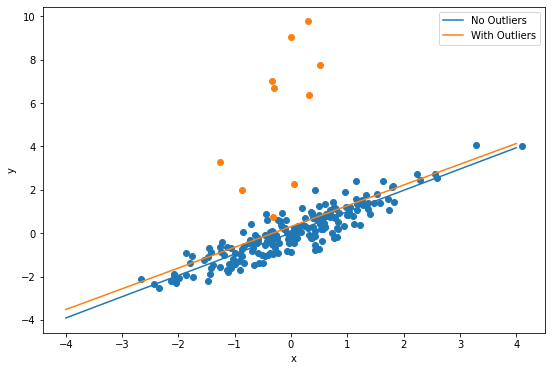

In [6]:
from sklearn.linear_model import LinearRegression

# toy data
plt.figure(figsize=(9, 6))
np.random.seed(2)
X = np.random.randn(200)
Y = X + np.random.randn(len(X)) * 0.5
model = LinearRegression()
model.fit(X.reshape(-1, 1), Y)
test_x = np.linspace(-4, 4, 100)
predictions = model.predict(test_x.reshape(-1, 1))
plt.plot(X, Y, 'o')
plt.plot(test_x, predictions, label='No Outliers', color='C0')

# add noise
sub_inds = np.random.choice(len(X), 10, replace=False)
XA = X.copy()
YA = Y.copy()
YA[sub_inds] = Y[sub_inds] + np.random.rand(len(sub_inds)) * 10
model.fit(XA.reshape(-1, 1), YA)
predictions = model.predict(test_x.reshape(-1, 1))
plt.plot(test_x, predictions, label='With Outliers')
plt.plot(XA[sub_inds], YA[sub_inds], 'o', color='C1')
plt.legend(loc='best')

plt.xlabel('x')
plt.ylabel('y')

Explained variance: [0.84578759 0.15421241]
Principal components:
First: [0.40260804 0.91537247]
Second: [0.40260804 0.91537247]


(-2.997856560392923, 4.447099727814635, -3.156507481358559, 10.378576493695691)

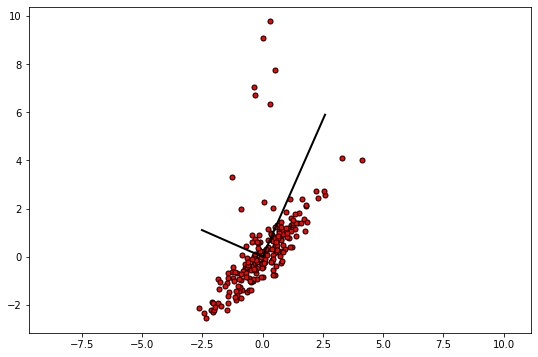

In [7]:
mean = np.array([0.0, 0.0])
cov  = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])

#X = np.random.multivariate_normal(mean, cov, 400)
X = np.stack([XA,YA]).T

pca = MyPCA(n_components=2)### YOUR CODE HERE ###
pca.fit(X)

print("Explained variance: {}".format(pca.explained_variance_ratio_))
print("Principal components:")
print("First: {}".format(pca.components_[0]))
print("Second: {}".format(pca.components_[0]))


plt.figure(figsize=(9, 6))

plt.scatter(X[:, 0], X[:, 1], s=25, c='r', marker='o', edgecolor='k')

for var_ratio, direction in zip(pca.explained_variance_ratio_, pca.components_):
    d = 7 * np.sqrt(var_ratio) * direction
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=2)

plt.axis('equal')

##### Watch in the next series (seminar): "Anomaly detection with PCA"

## 2. Singular Value Decomposition and PCA of an Image for data compression

In [10]:
!wget https://github.com/adasegroup/ML2023_seminars/tree/main/seminar14/fruits.png

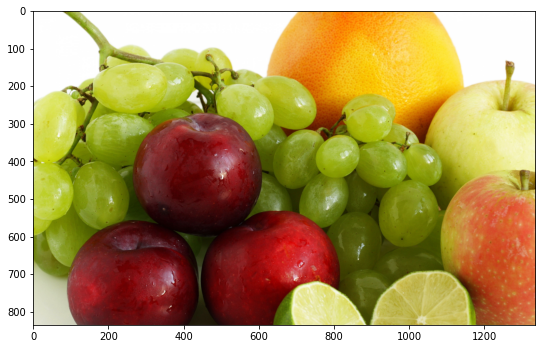

In [11]:
# library for images
from PIL import Image

img = Image.open('fruits.png')
imggray = img.convert('LA')
plt.figure(figsize=(9, 6));
plt.imshow(img);

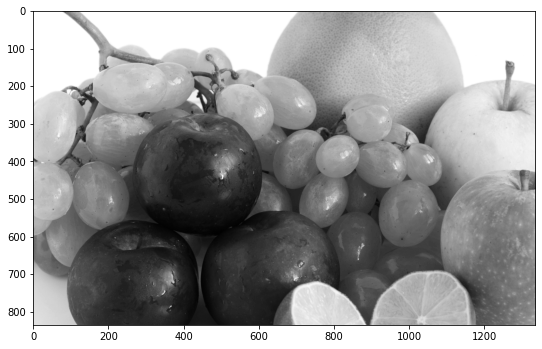

In [12]:
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray');

In [16]:
# you can try this one, yet it converges much longer

# U, sigma, V = MySVD(verbose=False)(imgmat)  
U, sigma, V = np.linalg.svd(imgmat)


Computing an approximation of the image using the first column of  $U$  and first row of  $V$  reproduces the most prominent feature of the image, the light area on top and the dark area on the bottom. The darkness of the arch causes the extra darkness in the middle of the reconstruction. Each column of pixels in this image is a different weighting of the same values,  $u_1$ :

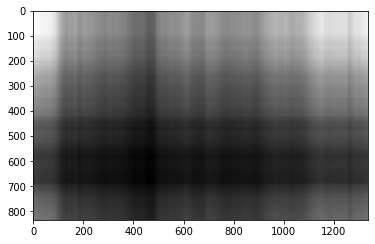

In [21]:
from sklearn.decomposition import PCA
### PCA
# pca = PCA(n_components=1).fit(imgmat) ### YOUR CODE HERE ###
# reconstimg = pca.inverse_transform(pca.transform(imgmat)) ### YOUR CODE HERE ###

### SVD
reconstimg = U[:,:1] * sigma[:1] * V[:1,:]### YOUR CODE HERE ###
plt.imshow(reconstimg, cmap='gray');

If we will be able to see the appearance from 2-m component?

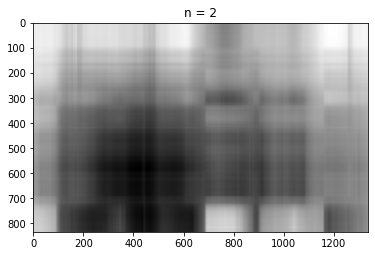

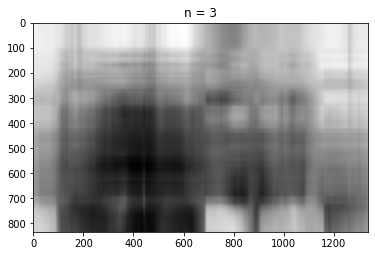

In [19]:
# for SVD
# for i in range(2, 4):
#     reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :]) ### YOUR CODE HERE ###
#     plt.imshow(reconstimg, cmap='gray')
#     title = "n = %s" % i
#     plt.title(title)
#     plt.show()
  
# for PCA
for i in range(2, 4):
    pca = PCA(n_components=i).fit(imgmat) ### YOUR CODE HERE ###
    reconstimg = pca.inverse_transform(pca.transform(imgmat)) ### YOUR CODE HERE ###
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()
# print(' Soooo clooosee .....')    
# plt.imshow(Image.open('Spongebob.png'));

### Ok, how many do we need?

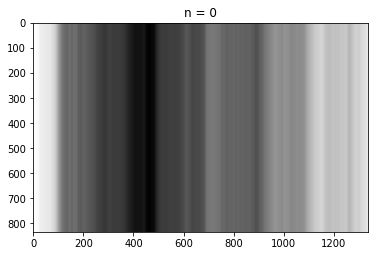

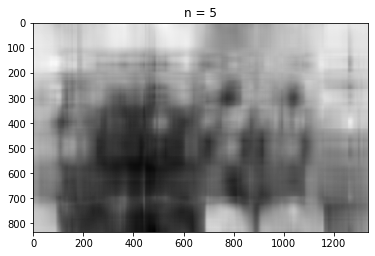

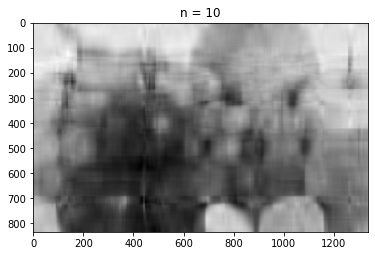

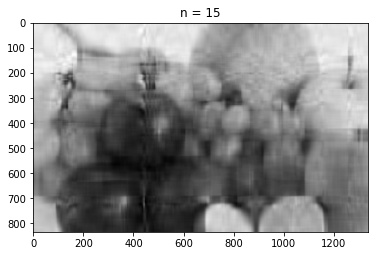

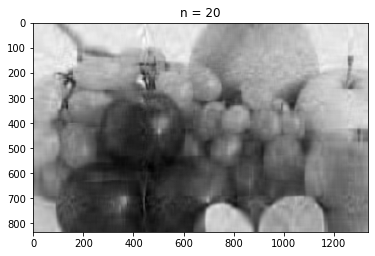

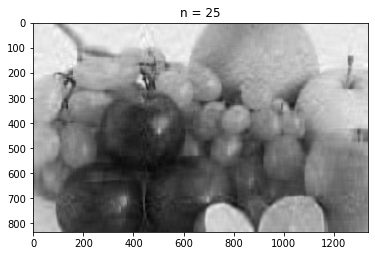

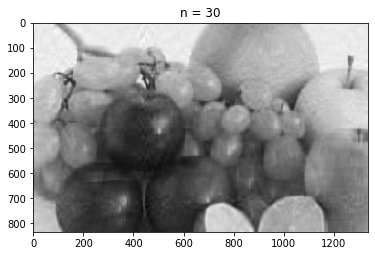

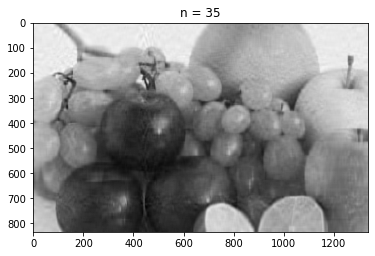

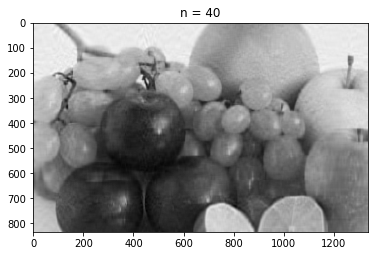

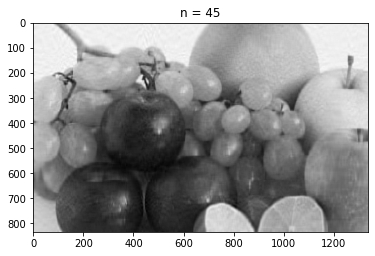

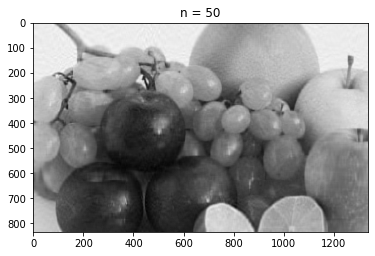

In [23]:
# ok how many do we need
for i in range(0, 51, 5):
    # for SVD
    # reconstimg =  np.matrix(U[:,:i]) * np.diag(sigma[:i]) * np.matrix(V[:i,:])### YOUR CODE HERE ###
    # for PCA
    pca = PCA(n_components=i).fit(imgmat) ### YOUR CODE HERE ###
    reconstimg = pca.inverse_transform(pca.transform(imgmat)) ### YOUR CODE HERE ###
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show() 
# plt.imshow(Image.open('realization.jpg'));

**For my perspective, `[:45]` reconstruction os good enough. Thus we can store less data.**

Questions: 
* What portion of the data we can discard this way?
* Can we estimate the intrinsic dimension of the image through PCA?

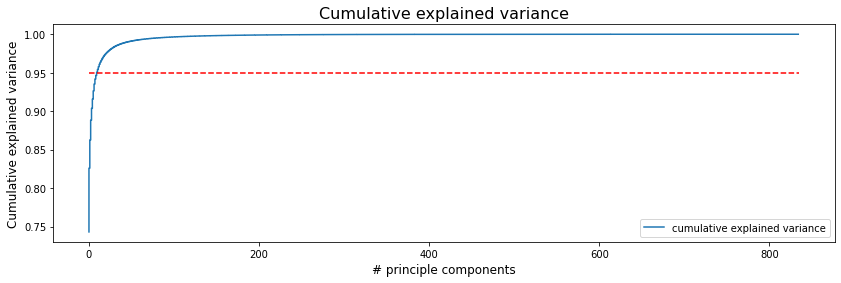

In [24]:
from sklearn.decomposition import PCA
pca = PCA().fit(imgmat)

plt.figure(figsize=(14, 4))

plt.step(range(len(pca.components_)), np.cumsum(pca.explained_variance_ratio_), label='cumulative explained variance'), ### YOUR CODE HERE ###, label='cumulative explained variance')
plt.title('Cumulative explained variance', fontsize=16)
plt.xlabel('# principle components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)

plt.legend(loc='lower right')
plt.hlines(y=0.95, xmin=0, xmax= len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')
plt.show()

## 3. The `Olivetti Faces dataset` component analysis.

In [30]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from numpy.random import RandomState


data = fetch_olivetti_faces(shuffle=True, random_state= 42 ).data
target = fetch_olivetti_faces(shuffle=True, random_state= 42).target

#data

Let's look at the dataset

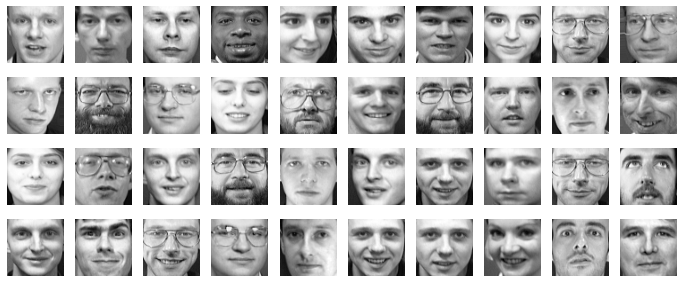

In [29]:
plt.figure(figsize=(12, 5))    
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(data[i].reshape((64, 64)), cmap='gray')
    plt.axis('off')

Let's look at the importance of the main components

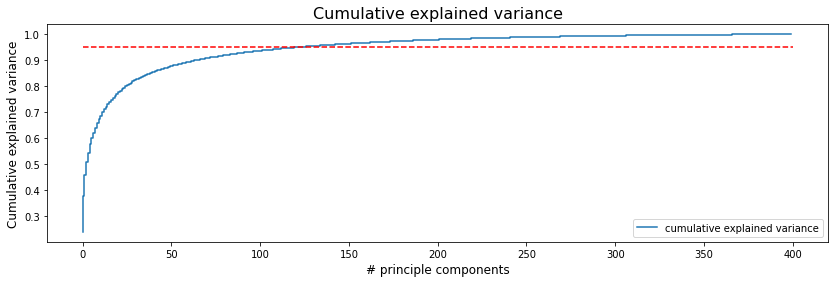

In [32]:
from sklearn.decomposition import PCA
pca = PCA().fit(data)

plt.figure(figsize=(14, 4))

plt.step(range(len(pca.components_)), np.cumsum(pca.explained_variance_ratio_), label='cumulative explained variance'), ### YOUR CODE HERE ###, label='cumulative explained variance')
plt.title('Cumulative explained variance', fontsize=16)
plt.xlabel('# principle components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)

plt.legend(loc='lower right')
plt.hlines(y=0.95, xmin=0, xmax= len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')
plt.show()

Let's look at the principial components

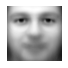

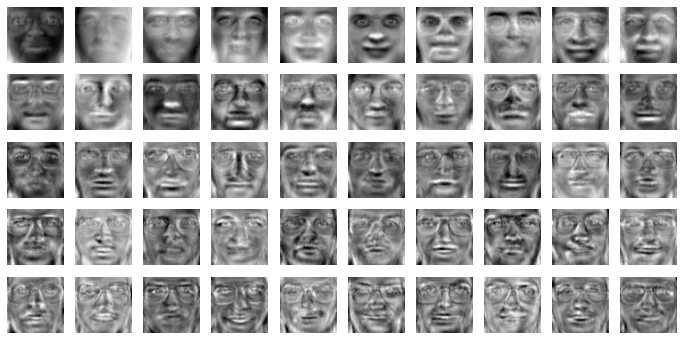

In [33]:
plt.figure(figsize=(1, 1))
plt.imshow(pca.mean_.reshape((64, 64)), cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))    
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(pca.components_[i].reshape((64, 64)), cmap='gray')
    plt.axis('off')

Questions:
* Who is these criminally looking guys?

Let's see how does the faces are reconstructed by principial components. For the sake of visibility, we take 10 components, yet is is not enough for good reconstruction:(

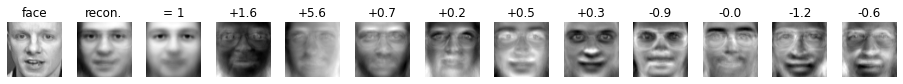

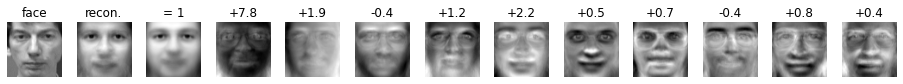

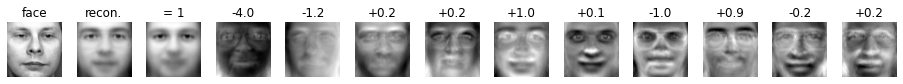

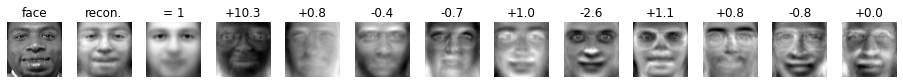

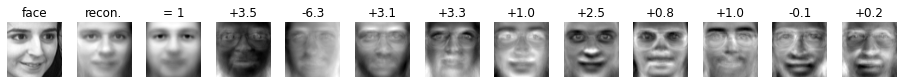

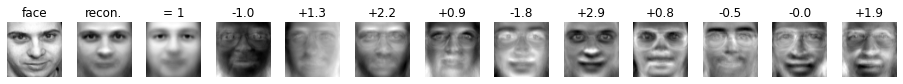

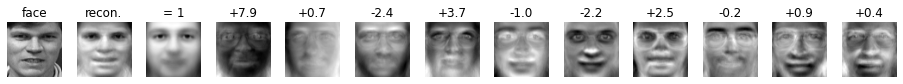

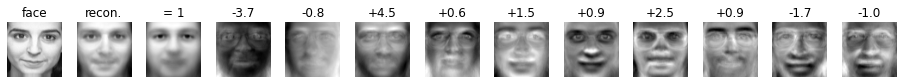

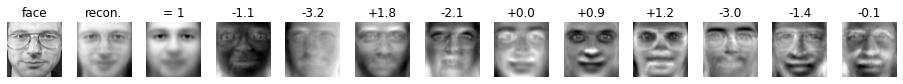

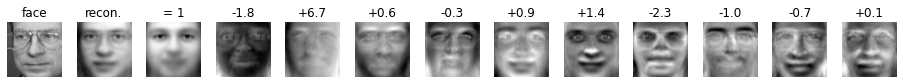

In [36]:
pca = PCA(n_components=10)
transform_X = pca.fit_transform(data)

for i in range(10):
    X_hat = pca.inverse_transform(transform_X[i]) # YOUR CODE HERE
    plt.figure(figsize=(16, 1))
    
    plt.subplot(1, 13, 1)
    plt.imshow(data[i].reshape((64, 64)), cmap='gray')
    plt.axis('off')
    plt.title('face')
    
    plt.subplot(1, 13, 2)
    plt.imshow(X_hat.reshape((64, 64)), cmap='gray')
    plt.axis('off')
    plt.title('recon.')
    
    plt.subplot(1, 13, 3)
    plt.imshow(pca.mean_.reshape((64, 64)), cmap='gray')
    plt.axis('off')
    plt.title('= 1')
    
    for j in range(10):
        plt.subplot(1, 13, 4 + j)
        plt.imshow(pca.components_[j].reshape((64, 64)), cmap='gray')
        plt.axis('off')
        plt.title('{}{:.1f}'.format('+' if transform_X[i, j] >= 0 else '', 
                                    transform_X[i, j]))
        
    plt.show()

2D visualization via PCA

In [37]:
from matplotlib import offsetbox
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_embedding(X, y, images_small=None, title=None):
    """
    Nice plot on first two components of embedding with Offsets.
    
    """
    # take only first two columns
    X = X[:, :2]
    # scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(13,8))
    ax = plt.subplot(111)
    
    for i in range(X.shape[0] - 1):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.RdGy(y[i]),
                 fontdict={'weight': 'bold', 'size': 12})
        if images_small is not None:
            imagebox = OffsetImage(images_small[i], zoom=.4, cmap = 'gray')
            ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                xycoords='data')                                  
            ax.add_artist(ab)
    
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-1:
                # don't show points that are too close
                continue
    if title is not None:
        plt.title(title)

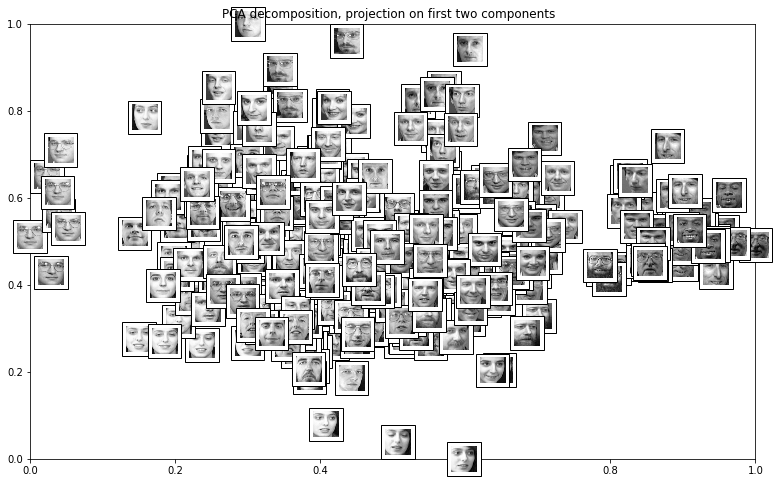

In [39]:
X_projected = PCA(400).fit_transform(data) ### YOUR CODE HERE ###
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "PCA decomposition, projection on first two components  ")

If I will change the number of components in here `PCA(100)` will it change the manifold?

## 4. Estimation of intrinsic dimension

From the paper: 


*There is a consensus in the high-dimensional data analysis community that the only reason any methods work in very high dimensions is that, in fact, the data are not truly high-dimensional. Rather, they are embedded in a high-dimensional space,
but can be efficiently summarized in a space of a much lower dimension, such as a nonlinear manifold.* 

*Then one can reduce dimension without losing much information for many types of real-life high-dimensional data, such as images, and avoid many of the “curses of dimensionality”. Learning these data manifolds can improve
performance in classification and other applications, but if the data structure is
complex and nonlinear, dimensionality reduction can be a hard problem.*

#####  NIPS 2004: https://papers.nips.cc/paper/2577-maximum-likelihood-estimation-of-intrinsic-dimension.pdf

### Idea of the method

The idea of the nearest-neighbor intrinsic dimension estimation is based on fact of the  that the number of sample points in $\mathbf{X} = \mathbb{R}^n$ falling into a ball around $\mathbf{x}$ is proportional to the radius of of the ball $R$, the dimension of the ball $d$ and the density $f(x)$ for which the well-known estimator exists

$$f(x) = \frac{k/n}{R^d V(d)},$$

where $V(d) = \pi^{d/2} [\Gamma (d/2+1)]^{-1}$ is the volume of unit sphere in $\mathbb{R}^d$ and $\Gamma(d) = (d - 1)!$ is the Gamma function.

Then the intrinsic dimension $d$ of the sample can be regressed out or estimated by the maximum likelihood appoarch.

In [40]:
"""
Implementation of 'Maximum Likelihood Estimation of Intrinsic Dimension' by Elizaveta Levina and Peter J. Bickel
 
how to use
----------
 
The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
(depending on how much you zoom into the data distribution you can find different dimesionality), so they
propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.
 
This code also provides a way to repeat the estimation with bootstrapping to estimate uncertainty.
 
Here is one example with swiss roll :
 
from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)
 
k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, 
                             mode='bootstrap', 
                             nb_iter=500, # nb_iter for bootstrapping
                             verbose=1, 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
# the shape of intdim_k_repeated is (nb_iter, size_of_interval) where 
# nb_iter is number of bootstrap iterations (here 500) and size_of_interval
# is (k2 - k1 + 1).
 
"""
# from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X) # distances between the samples and points
    dist = dist[:, 1:] # the distance between the first points to first points (as basis ) equals zero
    # the first non trivial point
    dist = dist[:, 0:k]# including points k-1
    assert dist.shape == (X.shape[0], k) # requirments are there is no equal points
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1]) # dinstance betveen the bayeasan statistics
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1): # in order to reduse the noise by eliminating of the nearest neibours 
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':# and each point we want to resample with repeating points to reduse the errors 
            #232 111 133 
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

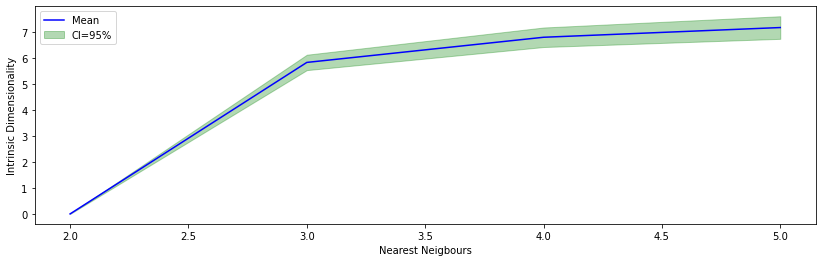

In [43]:
import warnings
warnings.filterwarnings("ignore")

k1 = 1 # start of interval(included)
k2 = 5 # end of interval(included)
nb_iter = 3 # more iterations more accuracy
# intrinsic_dim_scale_interval gives better estimation
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             ### YOUR CODE HERE ###, 
                             data,
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

x = np.arange(k1, k2+1)

plt.figure(figsize=(14, 4))
plt.plot(x, np.mean(intdim_k_repeated, axis=0), 'b', label='Mean') # it is the mean walue
plt.fill_between(x, 
                 np.mean(intdim_k_repeated, axis=0) - 
                 2 * np.std(intdim_k_repeated, axis=0),
                 np.mean(intdim_k_repeated, axis=0) + 
                 2 * np.std(intdim_k_repeated, axis=0),
                 alpha=0.3,
                 label='CI=95%',
                 color='g')
plt.xlabel("Nearest Neigbours")
plt.ylabel("Intrinsic Dimensionality")
plt.legend()
plt.show()

## 5. Manifold learning  

It is big part of research on the application of geometry and in particular differential geometry to machine learning. If you are interested - next term it will be course by **Prof. Bernstein** - you are welcomed. 

We are going to touch a couple popular algorithms from: https://scikit-learn.org/stable/modules/manifold.html

The manifold learning methods also assumes nono-linear algorithms for dimensionality reduction.

Questions:
* Is `PCA` linear?
* Can we compose non-linear `PCA` from the linear?

Principal Component Analysis (PCA), Independent Component Analysis, Linear Discriminant Analysis, and others. These algorithms define specific rubrics to choose an good linear projection of the data. 

These methods can be powerful, but often miss important non-linear structure in the data.


**Lets go with some other liner method : Independent Component Analysis `ICA`.** 
FastICA algorithm: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

<img src="https://cf2.ppt-online.org/files2/slide/c/CarDgVY6t91bypGImvqBcR3OdAjWhFTZ2JQxL4ofM/slide-6.jpg" alt="Drawing" style="width: 700px;" />
Credit for: https://cf2.ppt-online.org/files2/slide/c/CarDgVY6t91bypGImvqBcR3OdAjWhFTZ2JQxL4ofM/slide-6.jpg

In [44]:
# let's leave 20 peaple from faces to get more comprehencible visualisation

data = fetch_olivetti_faces(shuffle=True, random_state= 42 ).data
target = fetch_olivetti_faces(shuffle=True, random_state= 42).target


data = data[target <20] ### YOUR CODE HERE ###
target = target[target <20] ### YOUR CODE HERE ###

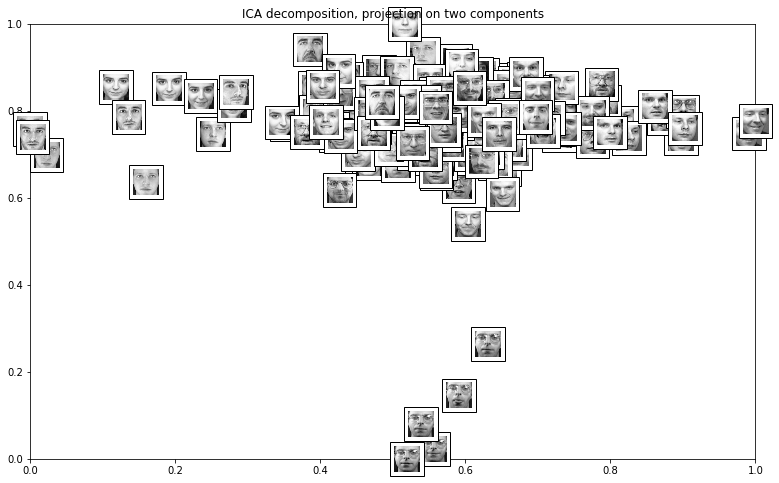

In [46]:
from sklearn.decomposition import FastICA 

X_projected = FastICA(20, random_state = 42).fit_transform(data) ### YOUR CODE HERE ###
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "ICA decomposition, projection on two components")

Will the decomposition change with the `n_components` changed?

**The most popular nonlinear algorithms: tSNE,  MDS, Isomap**

t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

1. For each data point $x_i$ we’ll center a Gaussian distribution over that point. Then we measure the density of all points $x_j$ under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities $P_{ij}$ for all points in higher dimentional space.

2. Get the second set of probablities $Q_{ij}$ for Cauchy distribution (with is Students t-distribution with one degree of freedom), which allow for better modeling of far apart distances, becouse of heavier tails.

3. Map these two sets of probabilities ($ P_{ij}; Q_{ij}$)to each other, optimiing KL-divergence.

Where Kullback–Leibler divergence can be defined as 

$$ D_{KL} (P || Q) = \sum P(x) log(\frac{P(x)}{Q(x)})$$

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 4.201303
[t-SNE] Computed conditional probabilities in 0.025s
[t-SNE] Iteration 50: error = 50.8396225, gradient norm = 0.0000001 (50 iterations in 0.136s)
[t-SNE] Iteration 100: error = 50.8237305, gradient norm = 0.0000000 (50 iterations in 0.082s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 50.823730
[t-SNE] Iteration 150: error = 0.5849583, gradient norm = 0.0090018 (50 iterations in 0.054s)
[t-SNE] Iteration 200: error = 0.4275265, gradient norm = 0.0012395 (50 iterations in 0.052s)
[t-SNE] Iteration 250: error = 0.4078509, gradient norm = 0.0005827 (50 iterations in 0.048s)
[t-SNE] Iteration 300: error = 0.4026586, gradient norm = 0.0004282 (50 iterations in 0.057s)
[t-SNE] Iterati

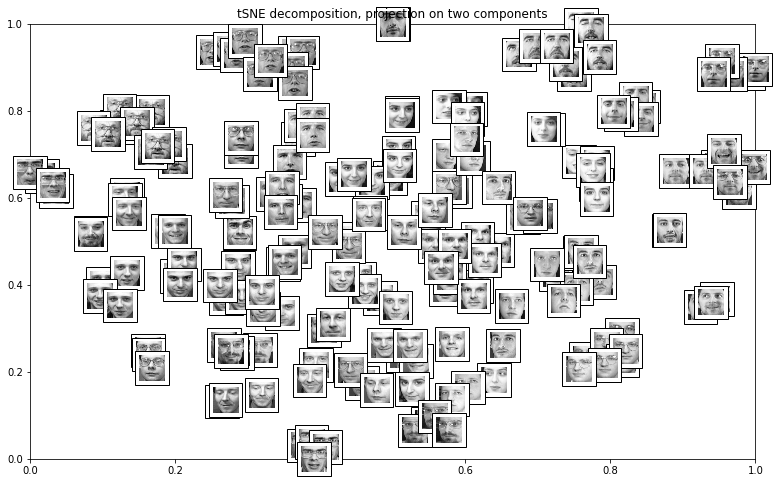

In [47]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, n_iter = 1000, metric='euclidean', learning_rate= 10, verbose=2, random_state = 42) ### YOUR CODE HERE ###

X_projected = tsne.fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "tSNE decomposition, projection on two components")

The effect of the perplexity

In [50]:
from sklearn.datasets import make_blobs

In [51]:
X, y = make_blobs(n_samples=500, n_features=10, centers=5)

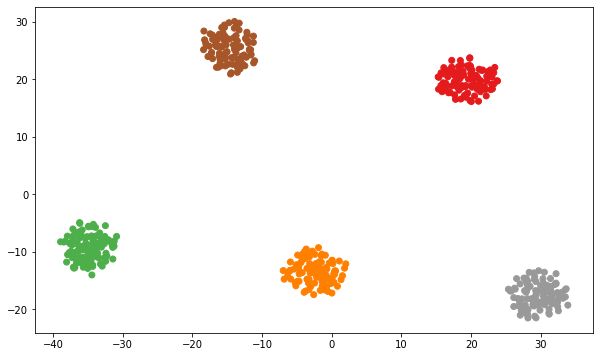

In [52]:
tsne = TSNE(n_components=2)
X_hat = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_hat[:, 0], X_hat[:, 1], c=y, cmap='Set1')
plt.show()

Let's see how does the displacement of points in the 2D space changes with respect to the `perplexity` paremter (smoothed effective number of the neighbours)

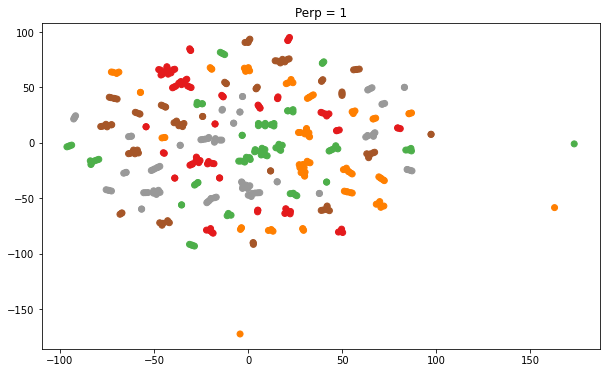

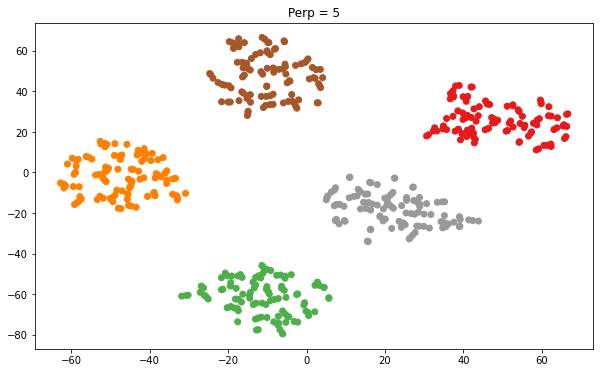

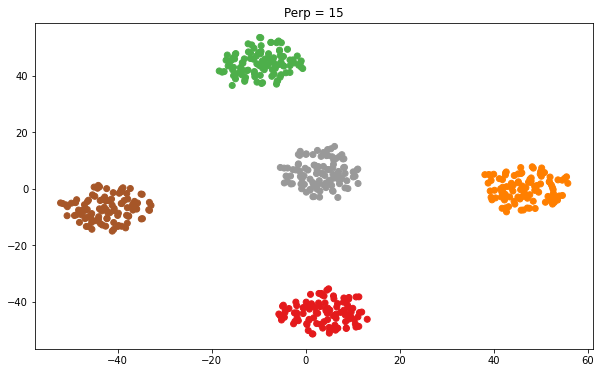

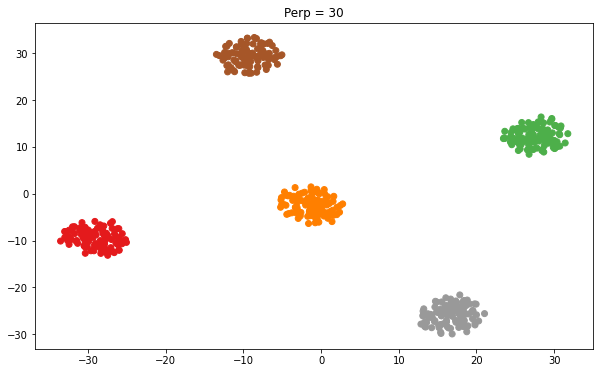

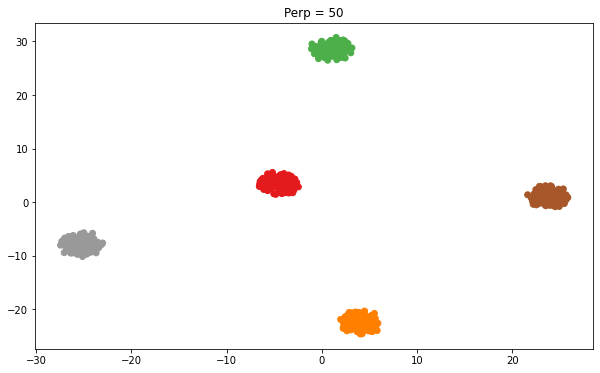

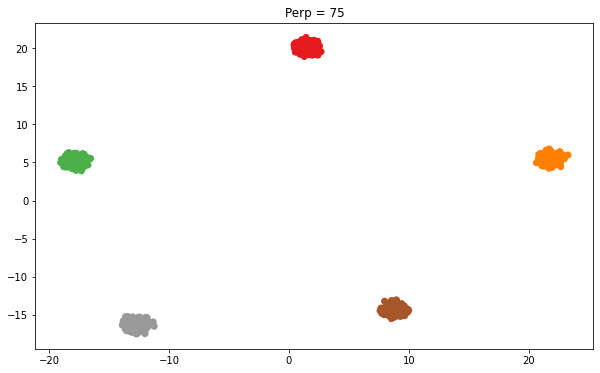

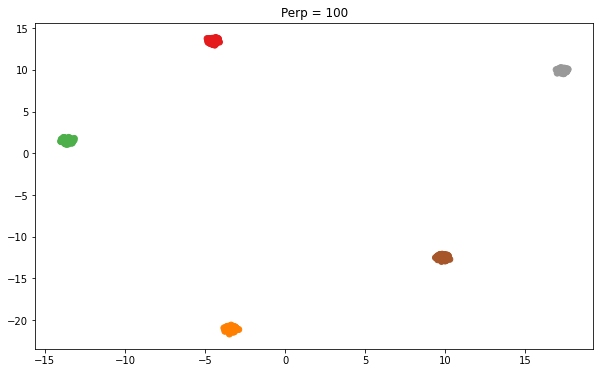

In [53]:
for perplexity in [1, 5, 15, 30, 50, 75, 100]:

    tsne = TSNE(n_components=2, perplexity=perplexity)
    X_hat = tsne.fit_transform(X)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_hat[:, 0], X_hat[:, 1], c=y, cmap='Set1')
    plt.title('Perp = {}'.format(perplexity))
    plt.show()

### Multi-dimensional Scaling (MDS)

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

*Modern Multidimensional Scaling - Theory and Applications, Borg, I.; Groenen P. Springer Series in Statistics (1997)*

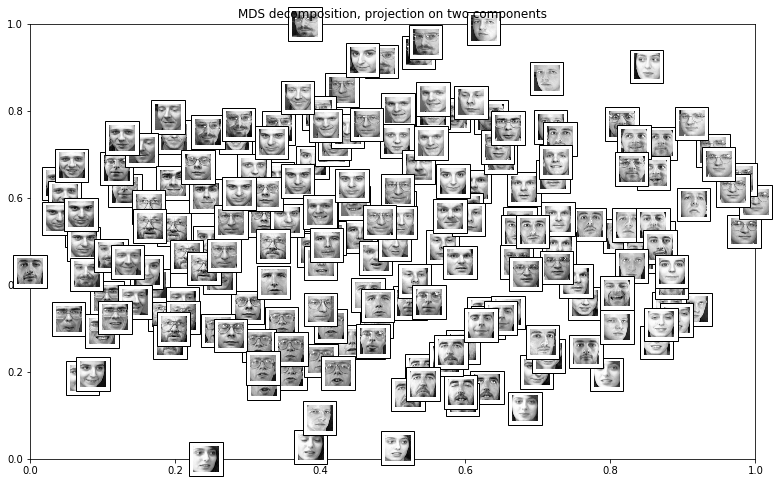

In [56]:
from sklearn.manifold import MDS

X_projected = MDS(n_components=2).fit_transform(data) ### YOUR CODE HERE ###
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "MDS decomposition, projection on two components")

### Isometric Mapping (Isomap)

Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points. Goes in three stages:

1. **Nearest neighbor search**. 

2. **Shortest-path graph search.**

3. **MDS with respect to the geodesic distances**.

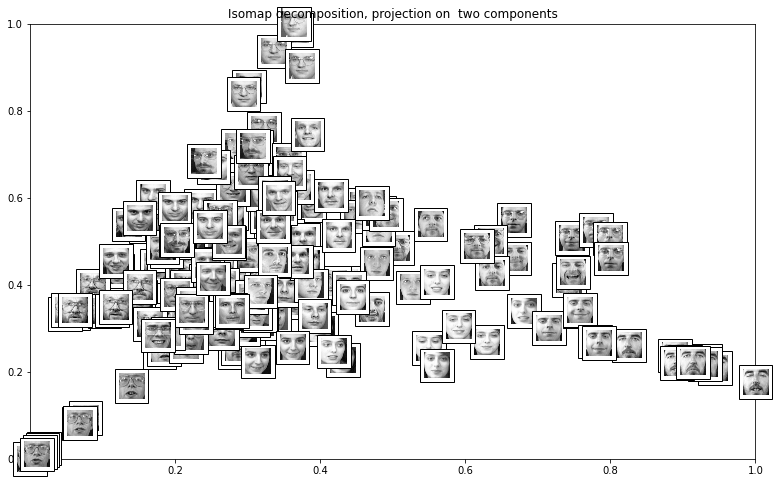

In [54]:
from sklearn.manifold import Isomap

X_projected = Isomap(n_components=2).fit_transform(data) ### YOUR CODE HERE ###
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "Isomap decomposition, projection on  two components")

### Multi-dimensional Scaling (MDS)

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

*Modern Multidimensional Scaling - Theory and Applications, Borg, I.; Groenen P. Springer Series in Statistics (1997)*

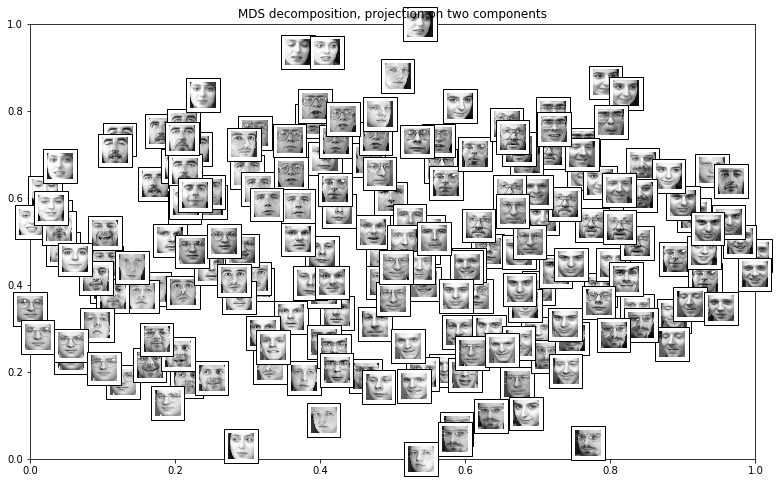

In [55]:
from sklearn.manifold import MDS

X_projected = MDS(n_components=2).fit_transform(data) ### YOUR CODE HERE ###
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "MDS decomposition, projection on two components")